### Setup

In [1]:
import pandas as pd
import os
import requests
import numpy as np
from bs4 import BeautifulSoup
import datetime
import re

#image analysis
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
TODAY = datetime.datetime.today()
uac_url = 'https://utahavalanchecenter.org'

def generate_forecast_url(date, region):
    return f"https://utahavalanchecenter.org/forecast/{region.replace(' ', '-').lower()}/{date.month}/{date.day}/{date.year}"

def plot_image(image, axis = False):
    plt.imshow(image)
    if not axis:
        plt.axis('off')
    plt.show()
    return
    

In [3]:
todays_forecast_url = generate_forecast_url(TODAY, 'Salt Lake')
page = requests.get(todays_forecast_url)
soup = BeautifulSoup(page.content, 'html5')
print(todays_forecast_url)

https://utahavalanchecenter.org/forecast/salt-lake/4/8/2023


https://utahavalanchecenter.org/sites/default/files/forecast/202304/20230408-070327-2.png
PNG (400, 440) RGBA


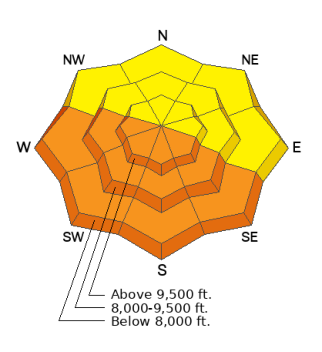

In [4]:
rose_url = uac_url + soup.find("img", class_="full-width compass-width sm-pb3").get('src')
print(rose_url)

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

rose = Image.open(requests.get(rose_url, stream=True).raw)
print(rose.format, rose.size, rose.mode)

plot_image(rose)

#### Testing PIL: Cut, Paste, and Merging

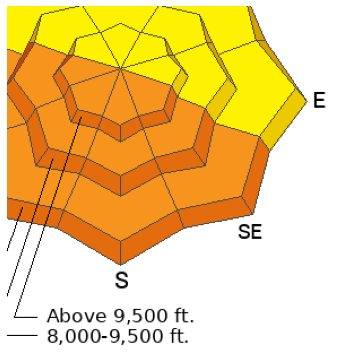

In [5]:
im = Image.open(requests.get(rose_url, stream=True).raw)
box = (100, 100, 400, 400)
region = im.crop(box)
plot_image(region)

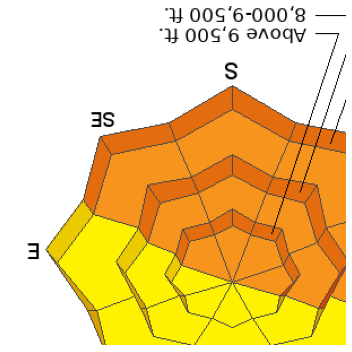

In [6]:
region = region.transpose(Image.Transpose.ROTATE_180)
im.paste(region, box)
plot_image(region)

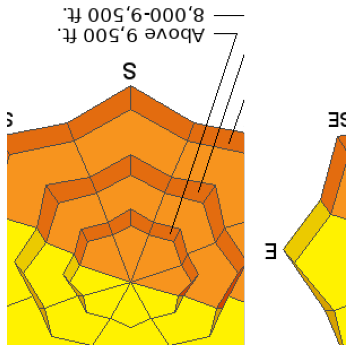

In [7]:
def roll(im, delta):
    """Roll an image sideways."""
    xsize, ysize = im.size

    delta = delta % xsize
    if delta == 0:
        return im

    part1 = im.crop((0, 0, delta, ysize))
    part2 = im.crop((delta, 0, xsize, ysize))
    im.paste(part1, (xsize - delta, 0, xsize, ysize))
    im.paste(part2, (0, 0, xsize - delta, ysize))

    return im

rolled = roll(region, 90)
plot_image(rolled)

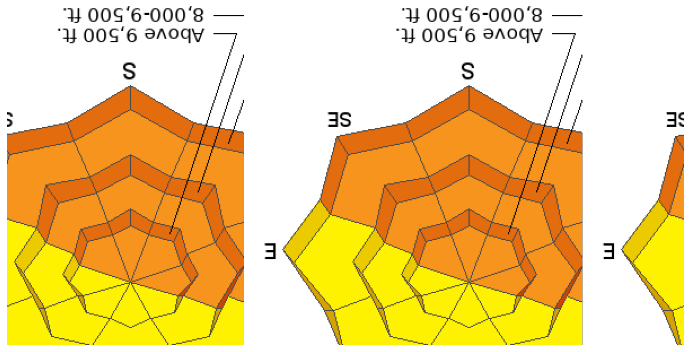

In [8]:
#merging images
def merge(im1, im2):
    w = im1.size[0] + im2.size[0]
    h = max(im1.size[1], im2.size[1])
    im = Image.new("RGBA", (w, h))

    im.paste(im1)
    im.paste(im2, (im1.size[0], 0))

    return im

merged = merge(region, rolled)
plot_image(merged)

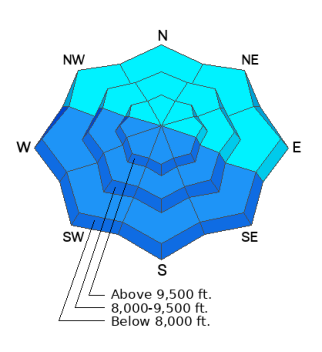

In [9]:
r, g, b, a = rose.split()
rearrange_bands = Image.merge("RGBA", (b, g, r, a))
plot_image(rearrange_bands)

### Identifying Pixels

We need to identify the individual aspects and elevations and extract the RGB values for each. From this we can infer the avalanche danger.

('N', 'High') coordinates are (200, 130) and rgba is (255, 242, 0, 255)
('NE', 'High') coordinates are (225, 135) and rgba is (255, 242, 0, 255)
('NW', 'High') coordinates are (175, 135) and rgba is (255, 242, 0, 255)
('W', 'High') coordinates are (165, 155) and rgba is (247, 148, 30, 255)
('E', 'High') coordinates are (235, 155) and rgba is (255, 242, 0, 255)
('SW', 'High') coordinates are (175, 175) and rgba is (247, 148, 30, 255)
('S', 'High') coordinates are (200, 185) and rgba is (247, 148, 30, 255)
('SE', 'High') coordinates are (225, 175) and rgba is (247, 148, 30, 255)
('N', 'Mid') coordinates are (200, 100) and rgba is (255, 242, 0, 255)
('NE', 'Mid') coordinates are (250, 115) and rgba is (255, 242, 0, 255)
('NW', 'Mid') coordinates are (150, 115) and rgba is (255, 242, 0, 255)
('W', 'Mid') coordinates are (125, 165) and rgba is (247, 148, 30, 255)
('E', 'Mid') coordinates are (275, 165) and rgba is (255, 242, 0, 255)
('SW', 'Mid') coordinates are (145, 215) and rgba is (247,

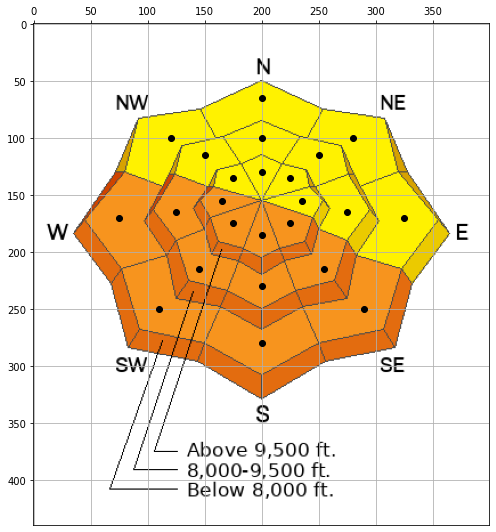

In [10]:
fig, ax = plt.subplots(figsize=[15,7.5])
ax.imshow(rose)
ax.grid(visible=True)
ax.xaxis.tick_top()
#coordinates for each elevation and aspect
#elevations are Low (<8000), Mid(8-95000), and High (>9500)
#(Aspect, Elevation) = (x,y)
rose_coord = {('N', 'High'): (200, 130),
              ('NE', 'High') : (225, 135),
              ('NW', 'High') : (175, 135),
              ('W', 'High') : (165, 155),
              ('E', 'High') : (235, 155),
              ('SW', 'High') : (175, 175), 
              ('S', 'High'): (200, 185), 
              ('SE', 'High'): (225, 175), 
              ('N', 'Mid'):(200, 100),
              ('NE', 'Mid'):(250, 115),
              ('NW', 'Mid'): (150, 115),
              ('W', 'Mid'):(125, 165),
              ('E', 'Mid'):(275, 165),
              ('SW', 'Mid'):(145, 215), 
              ('S', 'Mid') : (200, 230),
              ('SE', 'Mid'):(255, 215),
              ('N', 'Low'):(200, 65),
              ('NE', 'Low'):(280, 100),
              ('NW', 'Low'):(120, 100),
              ('W', 'Low'):(75, 170),
              ('E', 'Low'):(325, 170),
              ('SW', 'Low'):(110, 250), 
              ('S', 'Low'):(200, 280), 
              ('SE', 'Low'):(290, 250)}


rose_rgb = {}
pix = rose.load()
for region in rose_coord:
    x,y = rose_coord[region]
    ax.plot(x, y, 'k', marker = 'o', markersize=6)
    rose_rgb[region] = pix[x,y]
    print(region, 'coordinates are', rose_coord[region], 'and rgba is',rose_rgb[region])

#### Avalanche Danger Color Scale
Unfortunately the color scale presented in each forecast as 5 different images of colors genrated by the html (or JS) script. Each color represents each of the different levels of danger we give to avalanches (low, moderate, considerable, high, extreme). I took a screenshot of the scale so we can extract the rgb values for each danger.

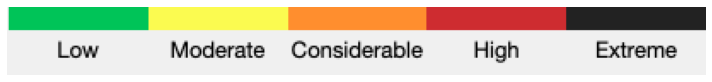

In [11]:
danger_scale = Image.open('danger_scale.png')
plot_image(danger_scale)

In [12]:
#found this nice bit of code on stackexchange
def classify_color(rgb_tuple):
    # eg. rgb_tuple = (2,44,300)

    # add as many colors as appropriate here, but for
    # the stated use case you just want to see if your
    # pixel is 'more red' or 'more green'
    colors = {"red": (255, 0, 0),
              "green" : (0,255,0),
              "yellow": (255, 255, 0),
              "orange": (255, 128, 0),
              "black" : (0, 0,0)
              }

    manhattan = lambda x,y : abs(x[0] - y[0]) + abs(x[1] - y[1]) + abs(x[2] - y[2]) 
    distances = {k: manhattan(v, rgb_tuple) for k, v in colors.items()}
    color = min(distances, key=distances.get)
    return color

Low rgba values are (0, 196, 88, 255) which is classified as green
Moderate rgba values are (251, 251, 80, 255) which is classified as yellow
Considerable rgba values are (255, 142, 46, 255) which is classified as orange
High rgba values are (206, 44, 48, 255) which is classified as red
Extreme rgba values are (34, 34, 34, 255) which is classified as black


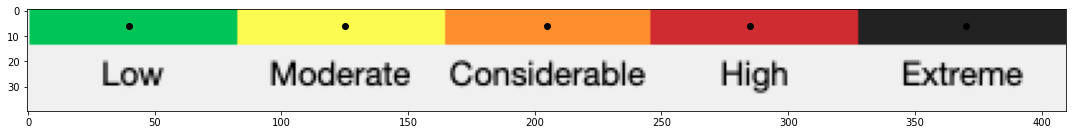

In [13]:
fig, ax = plt.subplots(figsize=[15,7.5])
ax.imshow(danger_scale)

level_coords = {}
level_coords['Low'] = (40,6)
level_coords['Moderate'] = (125,6)
level_coords['Considerable'] = (205,6)
level_coords['High'] = (285,6)
level_coords['Extreme'] = (370,6)

level_rgb = {}
pix = danger_scale.load()
for level in level_coords:
    x, y = level_coords[level]
    plt.plot(x,y, 'k', marker='o', markersize=6)
    level_rgb[level] = pix[x,y]
    class_label = classify_color(level_rgb[level][0:3])
    print(level, 'rgba values are', level_rgb[level],'which is classified as', class_label)

In [14]:
def classify_danger(rgb_tuple):
    '''takes an rgb_tuple and returns the danger rating of that color based on the minimum manhattan distance
    of the rgb value from the specific danger values linked to specific colors. 
    Low -> Green, Moderate -> Yellow, Considerable -> Orange, High -> Red, Extreme -> Black
    eg. rgb_tuple = (5,255,6)-->'Green'-->'Low'''

    colors = {"Low" : (0,255,0),
              "Moderate": (255, 255, 0),
              "Considerable": (255, 128, 0),
              "High": (255, 0, 0),
              "Extreme" : (0, 0,0)
              }

    manhattan = lambda x,y : abs(x[0] - y[0]) + abs(x[1] - y[1]) + abs(x[2] - y[2]) #uses manhatten distance
    distances = {k: manhattan(v, rgb_tuple) for k, v in colors.items()}
    danger = min(distances, key=distances.get)
    return danger

In [15]:
def get_rose_url(forecast_url):
    page = requests.get(forecast_url)
    soup = BeautifulSoup(page.content, 'html5')
    rose_url = uac_url + soup.find("img", class_="full-width compass-width sm-pb3").get('src')
    return rose_url

def get_danger_rose(forecast_url, plot = False):
    rose_url = get_rose_url(forecast_url)
    rose = Image.open(requests.get(rose_url, stream=True).raw)
    if plot:
        plot_image(rose)
    rose_danger = {}
    pix = rose.load()
    for region in rose_coord:
        x,y = rose_coord[region]
        if plot:
            ax.plot(x, y, 'k', marker = 'o', markersize=6)
        rose_danger[region] = classify_danger(pix[x,y][0:3])
        #print(region, 'the danger is', rose_danger[region])
    return rose_danger

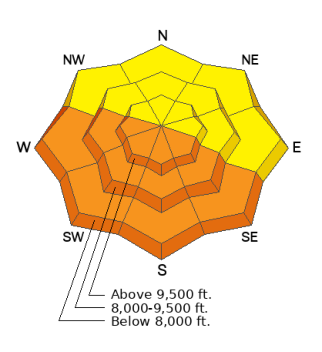

{('N', 'High'): 'Moderate',
 ('NE', 'High'): 'Moderate',
 ('NW', 'High'): 'Moderate',
 ('W', 'High'): 'Considerable',
 ('E', 'High'): 'Moderate',
 ('SW', 'High'): 'Considerable',
 ('S', 'High'): 'Considerable',
 ('SE', 'High'): 'Considerable',
 ('N', 'Mid'): 'Moderate',
 ('NE', 'Mid'): 'Moderate',
 ('NW', 'Mid'): 'Moderate',
 ('W', 'Mid'): 'Considerable',
 ('E', 'Mid'): 'Moderate',
 ('SW', 'Mid'): 'Considerable',
 ('S', 'Mid'): 'Considerable',
 ('SE', 'Mid'): 'Considerable',
 ('N', 'Low'): 'Moderate',
 ('NE', 'Low'): 'Moderate',
 ('NW', 'Low'): 'Moderate',
 ('W', 'Low'): 'Considerable',
 ('E', 'Low'): 'Moderate',
 ('SW', 'Low'): 'Considerable',
 ('S', 'Low'): 'Considerable',
 ('SE', 'Low'): 'Considerable'}

In [16]:
get_danger_rose(todays_forecast_url, plot=True)

In [17]:
# Lets try a few random roses
def random_date_generator():
    #we want the date in the winter
    from random import randint
    date = datetime.date(randint(2018,2023),randint(1,4), randint(1,32))
    return date
print(random_date_generator())

2020-01-02


2023-02-17
https://utahavalanchecenter.org/forecast/salt-lake/2/17/2023


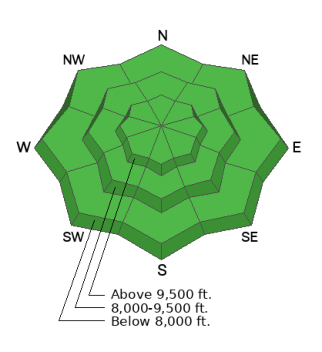

{('N', 'High'): 'Low',
 ('NE', 'High'): 'Low',
 ('NW', 'High'): 'Low',
 ('W', 'High'): 'Low',
 ('E', 'High'): 'Low',
 ('SW', 'High'): 'Low',
 ('S', 'High'): 'Low',
 ('SE', 'High'): 'Low',
 ('N', 'Mid'): 'Low',
 ('NE', 'Mid'): 'Low',
 ('NW', 'Mid'): 'Low',
 ('W', 'Mid'): 'Low',
 ('E', 'Mid'): 'Low',
 ('SW', 'Mid'): 'Low',
 ('S', 'Mid'): 'Low',
 ('SE', 'Mid'): 'Low',
 ('N', 'Low'): 'Low',
 ('NE', 'Low'): 'Low',
 ('NW', 'Low'): 'Low',
 ('W', 'Low'): 'Low',
 ('E', 'Low'): 'Low',
 ('SW', 'Low'): 'Low',
 ('S', 'Low'): 'Low',
 ('SE', 'Low'): 'Low'}

In [19]:
rand_date = random_date_generator()
print(rand_date)
forecast_url = generate_forecast_url(rand_date, 'Salt Lake')
print(forecast_url)
get_danger_rose(forecast_url, plot=True)

#### Liklihood and Size

In [20]:
problems = soup.findAll(class_='text_01 mb0')
problem_soups = {}
for problem in problems:
    print(problem.string)
    problem_type = problem.next_sibling.nextSibling.string
    print(problem_type)
    problem_info_soup = problem.parent.parent.nextSibling.nextSibling
    problem_soups[problem.string + ': ' + problem_type] = problem_info_soup

Avalanche Problem #1
Wet Snow
Avalanche Problem #2
Wind Drifted Snow
Avalanche Problem #3
Cornice


In [21]:
print(list(problem_soups.keys()))
problem1_soup = problem_soups[list(problem_soups.keys())[0]]
#print(problem1_soup)

PROBLEM_FIELDS = ['Location', 'Likelihood', 'Size']
problem1_imgs = {}
for field in PROBLEM_FIELDS:
    field_tag = problem1_soup.find(string=field).parent
    print(field_tag.string)
    img_tag = field_tag.next_sibling.next_sibling
    img_source_url = uac_url + img_tag.get('src')
    print(img_source_url)
    problem1_imgs[field] = img_source_url
#[img.get('src') for img in problem1_info.findAll("img")]

['Avalanche Problem #1: Wet Snow', 'Avalanche Problem #2: Wind Drifted Snow', 'Avalanche Problem #3: Cornice']
Location
https://utahavalanchecenter.org/sites/default/files/forecast/202304/20230408-070326-1.png
Likelihood
https://utahavalanchecenter.org/sites/all/themes/custom/basscss/images/icons/likelihood/likelihood_02.jpg
Size
https://utahavalanchecenter.org/sites/all/themes/custom/basscss/images/icons/size/size_03.jpg


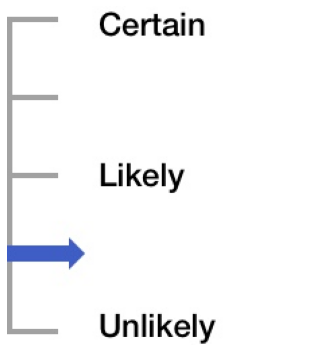

In [22]:
likelihood_url = problem1_imgs['Likelihood']
size_url = problem1_imgs['Size']
im_likelihood = Image.open(requests.get(likelihood_url, stream=True).raw)
im_size = Image.open(requests.get(size_url, stream = True).raw)
plot_image(im_likelihood)

('Certain', 5) coordinates are (35, 9) and rgba is (164, 164, 164)
('Very Likely', 4) coordinates are (35, 68) and rgba is (161, 161, 161)
('Likely', 3) coordinates are (35, 125) and rgba is (58, 96, 197)
('Somewhat Likely', 2) coordinates are (35, 183) and rgba is (159, 159, 159)
('Unlikely', 1) coordinates are (35, 241) and rgba is (164, 164, 164)


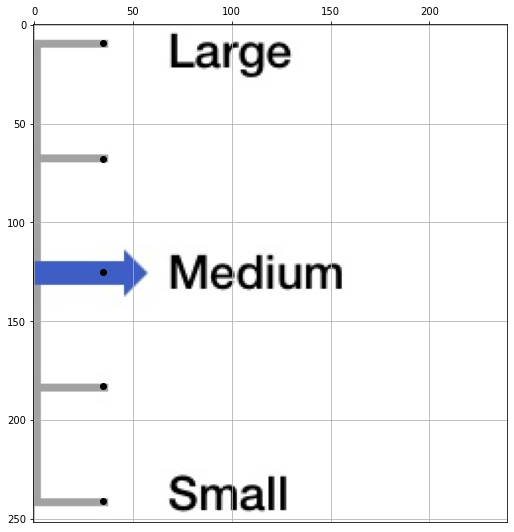

In [23]:
fig, ax = plt.subplots(figsize=[15,7.5])
ax.imshow(im_likelihood)
ax.grid(visible=True)
ax.xaxis.tick_top()
#coordinates of each certainty category
#Certainty, certainty_factor = (x,y)
scale_coord = {('Certain', 5): (35, 9),
               ('Very Likely', 4) : (35, 68),
              ('Likely', 3) : (35, 125),
              ('Somewhat Likely', 2) : (35, 183),
              ('Unlikely', 1) : (35, 241),
              }


scale_rgb = {}
pix = im_size.load()
for certainty in scale_coord:
    x,y = scale_coord[certainty]
    #x = x + 5
    ax.plot(x, y, 'k', marker = 'o', markersize=6)
    scale_rgb[certainty] = pix[x,y]
    print(certainty, 'coordinates are', scale_coord[certainty], 'and rgba is',scale_rgb[certainty])

('Somewhat Likely', 2)


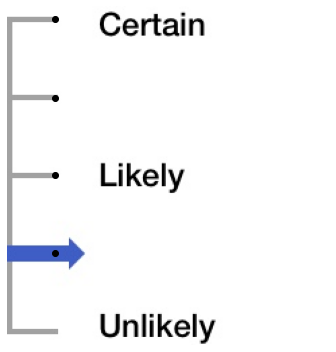

In [39]:
#add some colors to our old function
def classify_danger(rgb_tuple):
    '''takes an rgb_tuple and returns the danger rating of that color based on the minimum manhattan distance
    of the rgb value from the specific danger values linked to specific colors. 
    Low -> Green, Moderate -> Yellow, Considerable -> Orange, High -> Red, Extreme -> Black
    eg. rgb_tuple = (5,255,6)-->'Green'-->'Low. Present and Not Present categories are for location rose applications'''

    colors = {"Low" : (0,255,0),
              "Moderate": (255, 255, 0),
              "Considerable": (255, 128, 0),
              "High": (255, 0, 0),
              "Extreme" : (0, 0,0),
              "Present" : (102, 178, 255),
              "Not Present" : (192, 192, 192)
              }

    manhattan = lambda x,y : abs(x[0] - y[0]) + abs(x[1] - y[1]) + abs(x[2] - y[2]) #uses manhatten distance
    distances = {k: manhattan(v, rgb_tuple) for k, v in colors.items()}
    danger = min(distances, key=distances.get)
    return danger

def measure_likelihood(img_url, plot = False):
    #coordinates of each certainty category
    #Certainty, certainty_factor = (x,y)
    scale_coord = {('Certain', 5): (35, 9),
                   ('Very Likely', 4) : (35, 68),
                  ('Likely', 3) : (35, 125),
                  ('Somewhat Likely', 2) : (35, 183),
                  ('Unlikely', 1) : (35, 241),
                  }


    scale_reading = {}
    img_likelihood = Image.open(requests.get(img_url, stream=True).raw)
    if plot:
        plt.imshow(img_likelihood)
        plt.axis('off')
    pix = im_likelihood.load()
    for likelihood in scale_coord:
        x,y = scale_coord[likelihood]
        if plot:
            plt.plot(x, y, 'k', marker = 'o', markersize=6)
        scale_reading[likelihood] = classify_danger(pix[x,y][0:3])
        #print(likelihood, 'coordinates are', scale_coord[likelihood], 'and which reads as',scale_reading[likelihood])
        if scale_reading[likelihood] == 'Present':
            likelihood, likelihood_factor = likelihood
            return likelihood, likelihood_factor
    return None
    

print(measure_likelihood(likelihood_url, plot=True))

('Large', 5) coordinates are (35, 9) and which reads as Not Present
('Medium-Large', 4) coordinates are (35, 68) and which reads as Not Present
('Medium', 3) coordinates are (35, 125) and which reads as Present
('Medium', 3)


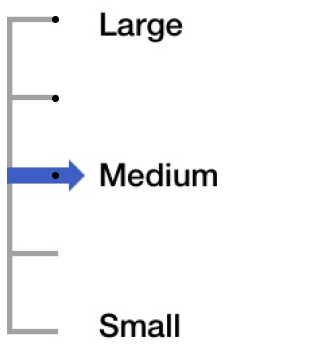

In [38]:
def measure_size(img_url, plot = False):
    #coordinates of each certainty category
    #Certainty, certainty_factor = (x,y)
    scale_coord = {('Large', 5): (35, 9),
                   ('Medium-Large', 4) : (35, 68),
                  ('Medium', 3) : (35, 125),
                  ('Medium-Small', 2) : (35, 183),
                  ('Small', 1) : (35, 241),
                  }


    scale_reading = {}
    img_size = Image.open(requests.get(img_url, stream=True).raw)
    if plot:
        plt.imshow(img_size)
        plt.axis('off')
    pix = im_size.load()
    for size in scale_coord:
        x,y = scale_coord[size]
        if plot:
            plt.plot(x, y, 'k', marker = 'o', markersize=6)
        scale_reading[size] = classify_danger(pix[x,y][0:3])
        #print(size, 'coordinates are', scale_coord[size], 'and which reads as',scale_reading[size])
        if scale_reading[size] == 'Present':
            size, size_factor = size
            return size, size_factor
    return None
    

print(measure_size(size_url, plot=True))